In [ ]:
# --- Notebook: 01_data_overview.ipynb ---
# Objective:
# Basic exploration of the CIC IoT-IDAD 2024 packet subset to confirm:
# - Device Identification target: device_mac
# - Intrusion Detection target: attack_label
# - Feasibility of a multitask model with shared encoder + two heads

In [ ]:
# ============================================================
# 1. Environment setup
# ============================================================

import sys
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 5)

# Assumes this notebook is in <project_root>/notebooks/
PROJECT_ROOT = Path(os.getcwd()).resolve().parents[0]
sys.path.append(str(PROJECT_ROOT))

from src.data.load_data import IoTDatasetLoader

In [3]:
# ============================================================
# 2. Configuration
# ============================================================

BASE_PATH = Path(
    "/Users/naeemulhassan/naeem-p/CIC_IoT_IDAD_2024/CIC_IoT_IDAD_Dataset_2024"
)

MAX_PACKET_FILES_FOR_SAMPLE = 10       # number of packet CSVs to sample
ROWS_PER_PACKET_FILE_SAMPLE = 50_000   # rows per file for sample

FULL_ROW_COUNT_SCAN = False            # True = full row count (slower)

ATTACK_KEYWORDS = {
    "ddos": "ddos",
    "mirai": "mirai",
    "dos": "dos",
    "benign": "benign",
    "recon": "recon",
    "spoof": "spoofing",
    "web": "web-based",
    "bruteforce": "brute force",
    "brute_force": "brute force",
    "brute-force": "brute force",
}

In [5]:

# ============================================================
# 3. Helper functions
# ============================================================

def infer_attack_label_from_filename(file_path: str) -> str:
    """
    Simple keyword-based fallback label from file path.
    """
    p = file_path.lower()
    for k, v in ATTACK_KEYWORDS.items():
        if k in p:
            return v
    return "unknown"


def detect_attack_label_column(df: pd.DataFrame, verbose: bool = True):
    """
    Try to locate the attack/benign label column using:
    1) column name (label/attack/family/category)
    2) overlap of string values with ATTACK_KEYWORDS
    """
    name_based = [
        c for c in df.columns
        if any(k in c.lower() for k in ["label", "attack", "family", "category"])
    ]

    content_based = []
    obj_cols = df.select_dtypes(include=["object"]).columns.tolist()

    for col in obj_cols:
        vals = (
            df[col]
            .dropna()
            .astype(str)
            .str.lower()
            .unique()
        )
        if len(set(vals) & set(ATTACK_KEYWORDS.values())) > 0:
            content_based.append(col)

    candidates = list(dict.fromkeys(name_based + content_based))

    if verbose:
        print("Attack label column detection:")
        print("  Name-based candidates   :", name_based)
        print("  Content-based candidates:", content_based)
        print("  Final candidate list    :", candidates)

    if not candidates:
        return None

    for c in candidates:
        if "label" in c.lower():
            return c
    return candidates[0]


def memory_usage_mb(df: pd.DataFrame) -> float:
    return df.memory_usage(deep=True).sum() / (1024 ** 2)


def count_rows_in_files(file_list, max_rows=None):
    """
    Count rows in a list of CSV files.
    If max_rows is set, read at most max_rows per file (approximate).
    """
    total = 0
    for path in file_list:
        if max_rows is None:
            df = pd.read_csv(path, usecols=[0])
        else:
            df = pd.read_csv(path, nrows=max_rows, usecols=[0])
        total += len(df)
    return total


REPORTS_DIR = PROJECT_ROOT / "reports"
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

In [6]:
# ============================================================
# 4. List files and categorise (packet vs flow)
# ============================================================

loader = IoTDatasetLoader(BASE_PATH)
all_files = loader.list_files()
print(f"Total CSV files found: {len(all_files)}")

packet_files = [
    f for f in all_files
    if ("packet" in f.lower()) or ("di_ad" in f.lower())
]
flow_files = [
    f for f in all_files
    if ("flow" in f.lower()) or ("cicflow" in f.lower())
]

if len(packet_files) == 0:
    packet_files = all_files

print(f"Packet-based CSV files (heuristic): {len(packet_files)}")
print(f"Flow-based   CSV files (heuristic): {len(flow_files)}")

print("\nExample packet-based files:")
for f in packet_files[:5]:
    print("  ", f)

print("\nExample flow-based files:")
for f in flow_files[:5]:
    print("  ", f)

Total CSV files found: 312
Packet-based CSV files (heuristic): 180
Flow-based   CSV files (heuristic): 132

Example packet-based files:
   /Users/naeemulhassan/naeem-p/CIC_IoT_IDAD_2024/CIC_IoT_IDAD_Dataset_2024/Device Identification_Anomaly Detection - Packet Based Features/BenignTraffic/BenignTraffic.csv
   /Users/naeemulhassan/naeem-p/CIC_IoT_IDAD_2024/CIC_IoT_IDAD_Dataset_2024/Device Identification_Anomaly Detection - Packet Based Features/BenignTraffic/BenignTraffic1.csv
   /Users/naeemulhassan/naeem-p/CIC_IoT_IDAD_2024/CIC_IoT_IDAD_Dataset_2024/Device Identification_Anomaly Detection - Packet Based Features/BenignTraffic/BenignTraffic2.csv
   /Users/naeemulhassan/naeem-p/CIC_IoT_IDAD_2024/CIC_IoT_IDAD_Dataset_2024/Device Identification_Anomaly Detection - Packet Based Features/BenignTraffic/BenignTraffic3.csv
   /Users/naeemulhassan/naeem-p/CIC_IoT_IDAD_2024/CIC_IoT_IDAD_Dataset_2024/Device Identification_Anomaly Detection - Packet Based Features/BruteForce/DictionaryBruteForce/D

In [7]:
# ============================================================
# 5. Approximate row counts 
# ============================================================

if FULL_ROW_COUNT_SCAN:
    print("\nComputing full row counts for packet and flow subsets...")
    packet_rows = count_rows_in_files(packet_files, max_rows=None)
    flow_rows = count_rows_in_files(flow_files, max_rows=None) if flow_files else 0
else:
    print("\nComputing approximate row counts (limited rows per file)...")
    packet_rows = count_rows_in_files(packet_files, max_rows=10_000)
    flow_rows = count_rows_in_files(flow_files, max_rows=10_000) if flow_files else 0

combined_rows = packet_rows + flow_rows

print("\n=== Approx. totals (dependent on FULL_ROW_COUNT_SCAN) ===")
print(f"  Packet-based rows ~ {packet_rows}")
print(f"  Flow-based rows   ~ {flow_rows}")
print(f"  Combined rows     ~ {combined_rows}")


Computing approximate row counts (limited rows per file)...

=== Approx. totals (dependent on FULL_ROW_COUNT_SCAN) ===
  Packet-based rows ~ 1766913
  Flow-based rows   ~ 1046948
  Combined rows     ~ 2813861


In [8]:
# ============================================================
# 6. Combined sample from packet-based files
# ============================================================

print("\nBuilding combined packet-based sample...")

sample_dfs = []
selected_packet_files = packet_files[:MAX_PACKET_FILES_FOR_SAMPLE]

for i, fp in enumerate(selected_packet_files, start=1):
    print(f"  [{i}/{len(selected_packet_files)}] Loading sample from {fp}")
    df_tmp = loader.load_single(fp, nrows=ROWS_PER_PACKET_FILE_SAMPLE)
    df_tmp["attack_label_from_file"] = infer_attack_label_from_filename(fp)
    df_tmp["source_file"] = Path(fp).name
    sample_dfs.append(df_tmp)

packet_sample = pd.concat(sample_dfs, ignore_index=True)
print("\nCombined packet_sample shape:", packet_sample.shape)
print("Approx memory usage (MB):", round(memory_usage_mb(packet_sample), 2))


Building combined packet-based sample...
  [1/10] Loading sample from /Users/naeemulhassan/naeem-p/CIC_IoT_IDAD_2024/CIC_IoT_IDAD_Dataset_2024/Device Identification_Anomaly Detection - Packet Based Features/BenignTraffic/BenignTraffic.csv
  [2/10] Loading sample from /Users/naeemulhassan/naeem-p/CIC_IoT_IDAD_2024/CIC_IoT_IDAD_Dataset_2024/Device Identification_Anomaly Detection - Packet Based Features/BenignTraffic/BenignTraffic1.csv
  [3/10] Loading sample from /Users/naeemulhassan/naeem-p/CIC_IoT_IDAD_2024/CIC_IoT_IDAD_Dataset_2024/Device Identification_Anomaly Detection - Packet Based Features/BenignTraffic/BenignTraffic2.csv
  [4/10] Loading sample from /Users/naeemulhassan/naeem-p/CIC_IoT_IDAD_2024/CIC_IoT_IDAD_Dataset_2024/Device Identification_Anomaly Detection - Packet Based Features/BenignTraffic/BenignTraffic3.csv
  [5/10] Loading sample from /Users/naeemulhassan/naeem-p/CIC_IoT_IDAD_2024/CIC_IoT_IDAD_Dataset_2024/Device Identification_Anomaly Detection - Packet Based Featur

/Users/naeemulhassan/naeem-p/Cloud-Deployed-Multitask-IoT-IDS/src/data/load_data.py:14: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filepath, nrows=nrows)


  [7/10] Loading sample from /Users/naeemulhassan/naeem-p/CIC_IoT_IDAD_2024/CIC_IoT_IDAD_Dataset_2024/Device Identification_Anomaly Detection - Packet Based Features/DDoS/DDoS-ACK_Fragmentation/DDoS-ACK_Fragmentation1.csv


/Users/naeemulhassan/naeem-p/Cloud-Deployed-Multitask-IoT-IDS/src/data/load_data.py:14: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filepath, nrows=nrows)


  [8/10] Loading sample from /Users/naeemulhassan/naeem-p/CIC_IoT_IDAD_2024/CIC_IoT_IDAD_Dataset_2024/Device Identification_Anomaly Detection - Packet Based Features/DDoS/DDoS-ACK_Fragmentation/DDoS-ACK_Fragmentation10.csv


/Users/naeemulhassan/naeem-p/Cloud-Deployed-Multitask-IoT-IDS/src/data/load_data.py:14: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filepath, nrows=nrows)


  [9/10] Loading sample from /Users/naeemulhassan/naeem-p/CIC_IoT_IDAD_2024/CIC_IoT_IDAD_Dataset_2024/Device Identification_Anomaly Detection - Packet Based Features/DDoS/DDoS-ACK_Fragmentation/DDoS-ACK_Fragmentation11.csv


/Users/naeemulhassan/naeem-p/Cloud-Deployed-Multitask-IoT-IDS/src/data/load_data.py:14: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filepath, nrows=nrows)


  [10/10] Loading sample from /Users/naeemulhassan/naeem-p/CIC_IoT_IDAD_2024/CIC_IoT_IDAD_Dataset_2024/Device Identification_Anomaly Detection - Packet Based Features/DDoS/DDoS-ACK_Fragmentation/DDoS-ACK_Fragmentation12.csv


/Users/naeemulhassan/naeem-p/Cloud-Deployed-Multitask-IoT-IDS/src/data/load_data.py:14: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filepath, nrows=nrows)



Combined packet_sample shape: (500000, 137)
Approx memory usage (MB): 963.28


In [9]:
# ============================================================
# 7. Column overview
# ============================================================

print("\nNumber of columns:", len(packet_sample.columns))
print(packet_sample.columns.tolist())
packet_sample.info()



Number of columns: 137
['stream', 'src_mac', 'dst_mac', 'src_ip', 'dst_ip', 'src_port', 'dst_port', 'inter_arrival_time', 'time_since_previously_displayed_frame', 'port_class_dst', 'l4_tcp', 'l4_udp', 'ttl', 'eth_size', 'tcp_window_size', 'payload_entropy', 'handshake_version', 'handshake_cipher_suites_length', 'handshake_ciphersuites', 'handshake_extensions_length', 'tls_server', 'handshake_sig_hash_alg_len', 'http_request_method', 'http_host', 'http_response_code', 'user_agent', 'dns_server', 'dns_query_type', 'dns_len_qry', 'dns_interval', 'dns_len_ans', 'device_mac', 'eth_src_oui', 'eth_dst_oui', 'payload_length', 'highest_layer', 'http_uri', 'http_content_len', 'http_content_type', 'icmp_type', 'icmp_checksum_status', 'icmp_data_size', 'jitter', 'stream_1_count', 'stream_1_mean', 'stream_1_var', 'src_ip_1_count', 'src_ip_1_mean', 'src_ip_1_var', 'src_ip_mac_1_count', 'src_ip_mac_1_mean', 'src_ip_mac_1_var', 'channel_1_count', 'channel_1_mean', 'channel_1_var', 'stream_jitter_1_su

In [10]:
# ============================================================
# 8. Device Identification: device_mac
# ============================================================

if "device_mac" not in packet_sample.columns:
    raise ValueError("device_mac column not found in packet_sample.")

device_unique = packet_sample["device_mac"].nunique()
print("\n[DI] device_mac unique count:", device_unique)

device_counts = packet_sample["device_mac"].value_counts().reset_index()
device_counts.columns = ["device_mac", "count"]

print("\nTop 20 devices by packet count:")
print(device_counts.head(20))

device_counts.to_csv(REPORTS_DIR / "eda_device_mac_counts.csv", index=False)



[DI] device_mac unique count: 79

Top 20 devices by packet count:
                  device_mac  count
0       Arlo Q Indoor Camera  92521
1          dc:a6:32:dc:27:d5  54346
2          dc:a6:32:c9:e4:ab  49730
3          dc:a6:32:c9:e5:ef  33698
4          dc:a6:32:c9:e4:d5  27817
5         Nest Indoor Camera  27299
6          dc:a6:32:c9:e4:90  27158
7          e4:5f:01:55:90:c4  25779
8          dc:a6:32:c9:e5:a4  21525
9          3c:18:a0:41:c3:a0  14971
10         ac:17:02:05:34:27  12818
11          Amazon Echo Show   8632
12         Amazon Echo Dot 2   7209
13         Sonos One Speaker   6305
14         Amazon Echo Dot 1   5096
15               Wyze Camera   4295
16            Netatmo Camera   3783
17        Amazon Echo Studio   3772
18         56:4f:8a:e1:f3:2d   3507
19  Google Nest Mini Speaker   3477


Attack label column detection:
  Name-based candidates   : ['attack_label_from_file']
  Content-based candidates: ['attack_label_from_file']
  Final candidate list    : ['attack_label_from_file']

Detected attack label column: attack_label_from_file

[AD] Attack label distribution (top 20):
  attack_label   count  percentage
0         ddos  250000        50.0
1       benign  200000        40.0
2  brute force   50000        10.0


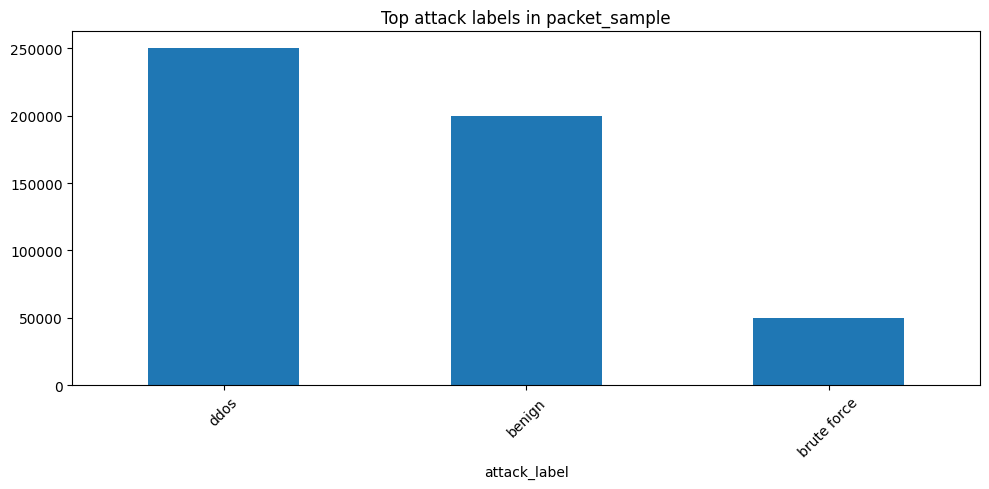

In [11]:
# ============================================================
# 9. Intrusion Detection: attack label
# ============================================================

attack_col = detect_attack_label_column(packet_sample, verbose=True)

if attack_col is not None:
    print(f"\nDetected attack label column: {attack_col}")
    packet_sample["attack_label"] = (
        packet_sample[attack_col]
        .astype(str)
        .str.strip()
        .str.lower()
    )
else:
    print("\nNo explicit attack label column detected; using filename-based label.")
    packet_sample["attack_label"] = (
        packet_sample["attack_label_from_file"]
        .astype(str)
        .str.strip()
        .str.lower()
    )

attack_counts = packet_sample["attack_label"].value_counts().reset_index()
attack_counts.columns = ["attack_label", "count"]
attack_counts["percentage"] = 100 * attack_counts["count"] / attack_counts["count"].sum()

print("\n[AD] Attack label distribution (top 20):")
print(attack_counts.head(20))

attack_counts.to_csv(REPORTS_DIR / "eda_attack_label_counts.csv", index=False)

attack_counts_head = attack_counts.head(10)
attack_counts_head.plot(
    x="attack_label",
    y="count",
    kind="bar",
    title="Top attack labels in packet_sample",
    legend=False,
    rot=45,
)
plt.tight_layout()
plt.show()

In [12]:
# ============================================================
# 10. Device vs attack crosstab (multitask evidence)
# ============================================================

crosstab_device_attack = (
    packet_sample
    .groupby(["device_mac", "attack_label"])
    .size()
    .reset_index(name="count")
)

print("\nSample of device vs attack crosstab (top 30 rows):")
print(crosstab_device_attack.sort_values("count", ascending=False).head(30))

crosstab_device_attack.to_csv(
    REPORTS_DIR / "eda_device_vs_attack_crosstab.csv", index=False
)


Sample of device vs attack crosstab (top 30 rows):
                   device_mac attack_label  count
43       Arlo Q Indoor Camera       benign  89195
187         dc:a6:32:c9:e4:ab         ddos  49726
199         dc:a6:32:dc:27:d5         ddos  42804
196         dc:a6:32:c9:e5:ef         ddos  33694
192         dc:a6:32:c9:e4:d5         ddos  27814
184         dc:a6:32:c9:e4:90         ddos  27155
201         e4:5f:01:55:90:c4         ddos  25777
114        Nest Indoor Camera       benign  22137
194         dc:a6:32:c9:e5:a4         ddos  21522
176         ac:17:02:05:34:27       benign  12818
198         dc:a6:32:dc:27:d5  brute force  10369
7           3c:18:a0:41:c3:a0       benign   8603
29           Amazon Echo Show       benign   7532
142         Sonos One Speaker         ddos   5517
26          Amazon Echo Dot 2       benign   5155
115        Nest Indoor Camera  brute force   5043
8           3c:18:a0:41:c3:a0  brute force   3508
16          94:39:e5:5d:27:a6  brute force   340

In [13]:
# ============================================================
# 11. Feature-type overview
# ============================================================

num_cols = packet_sample.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = packet_sample.select_dtypes(include=["object"]).columns.tolist()

print("\nNumeric columns count:", len(num_cols))
print("Categorical columns count:", len(cat_cols))

print("\nSample numeric columns:", num_cols[:20])
print("\nSample categorical columns:", cat_cols[:20])

numeric_stats = packet_sample[num_cols].describe().transpose()
numeric_stats.to_csv(REPORTS_DIR / "eda_numeric_feature_stats.csv")


Numeric columns count: 119
Categorical columns count: 19

Sample numeric columns: ['stream', 'src_port', 'dst_port', 'inter_arrival_time', 'time_since_previously_displayed_frame', 'port_class_dst', 'l4_tcp', 'l4_udp', 'ttl', 'eth_size', 'tcp_window_size', 'payload_entropy', 'handshake_cipher_suites_length', 'handshake_ciphersuites', 'handshake_extensions_length', 'handshake_sig_hash_alg_len', 'http_response_code', 'dns_query_type', 'dns_len_qry', 'dns_interval']

Sample categorical columns: ['src_mac', 'dst_mac', 'src_ip', 'dst_ip', 'handshake_version', 'tls_server', 'http_request_method', 'http_host', 'user_agent', 'dns_server', 'device_mac', 'eth_src_oui', 'eth_dst_oui', 'highest_layer', 'http_uri', 'http_content_type', 'attack_label_from_file', 'source_file', 'attack_label']


In [14]:
# ============================================================
# 11. Summary for methodology / supervision
# ============================================================

print("\n================ SUMMARY ================")
print(f"- Total packet_sample rows         : {len(packet_sample):,}")
print(f"- Device classes (device_mac)      : {device_unique}")
print(f"- Attack label column used         : {attack_col or 'attack_label_from_file'}")
print(f"- Number of distinct attack labels : {attack_counts['attack_label'].nunique()}")
print(f"- Numeric feature columns          : {len(num_cols)}")
print(f"- Categorical feature columns      : {len(cat_cols)}")
print("----------------------------------------")
print("Multitask justification:")
print("- Each packet has device_mac (device ID target) and attack_label (intrusion target).")
print("- Large number of packets across multiple devices and attack types.")
print("- Supports a shared encoder with two classification heads:")
print("  * Head 1: device identification (multi-class)")
print("  * Head 2: intrusion detection (multi-class)")
print("========================================")


================ SUMMARY ================
- Total packet_sample rows         : 500,000
- Device classes (device_mac)      : 79
- Attack label column used         : attack_label_from_file
- Number of distinct attack labels : 3
- Numeric feature columns          : 119
- Categorical feature columns      : 19
----------------------------------------
Multitask justification:
- Each packet has device_mac (device ID target) and attack_label (intrusion target).
- Large number of packets across multiple devices and attack types.
- Supports a shared encoder with two classification heads:
  * Head 1: device identification (multi-class)
  * Head 2: intrusion detection (multi-class)
